In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Theory

In [3]:
def plot_rdk_hist(fraction_subset, p_subset, p_background, num_dots, num_directions):
    p = {"s": p_subset, "b": p_background}
    num_group = dict(s=int(fraction_subset * num_dots))
    num_group["b"] = num_dots - num_group["s"]
    mu = {}
    sigma2 = {}
    mu_dir = {}
    sigma2_dir = {}
    titles = {"s": "subset", "b": "background", "t": "total"}
    dirn = {"s": -2, "b": num_directions // 2}
    for k in "sb":
        for d in "ci":
            if d == "c":
                p_cur = p[k]
            else:
                p_cur = 1 / num_directions
            mu[k, d] = num_group[k] * p_cur
            sigma2[k, d] = num_group[k] * p_cur * (1 - p_cur)
        for param_dir, param_dict in [(mu_dir, mu), (sigma2_dir, sigma2)]:
            param_dir[k] = np.ones(num_directions + 1) * param_dict[k, "i"]
            param_dir[k][dirn[k]] = param_dict[k, "c"]
            param_dir[k][-1] = param_dir[k][0]
    mu_dir["t"] = fraction_subset * mu_dir["s"] + (1 - fraction_subset) * mu_dir["b"]
    sigma2_dir["t"] = (
        fraction_subset * sigma2_dir["s"] + (1 - fraction_subset) * sigma2_dir["b"]
    )
    theta = np.linspace(0, 2 * np.pi, num_directions + 1)
    plt.figure(figsize=(16, 8))
    for i, k in enumerate("sbt"):
        normfac = 1 / np.amin(mu_dir[k])
        plt.subplot(1, 3, i + 1, polar=True)
        plt.polar(theta, normfac * mu_dir[k], color="C" + str(i))
        s = np.sqrt(sigma2_dir[k]) * 1.96
        plt.fill_between(
            theta,
            normfac * (mu_dir[k] - s),
            normfac * (mu_dir[k] + s),
            color="C" + str(i),
            alpha=0.2,
        )
        plt.title(titles[k] + "\n")
    plt.tight_layout()

In [97]:
import ipywidgets as widgets


@widgets.interact(
    fraction_subset=widgets.FloatSlider(0.1, min=0.0, max=1.0, step=0.1),
    p_subset=widgets.FloatSlider(0.9, min=0.0, max=1.0, step=0.1),
    p_background=widgets.FloatSlider(0.2, min=0.0, max=1.0, step=0.1),
    num_dots=widgets.IntSlider(500, min=10, max=1000, step=10),
    num_directions=widgets.IntSlider(180, min=10, max=360, step=10),
)
def plot_interactive(fraction_subset, p_subset, p_background, num_dots, num_directions):
    plot_rdk_hist(fraction_subset, p_subset, p_background, num_dots, num_directions)

interactive(children=(FloatSlider(value=0.1, description='fraction_subset', max=1.0), FloatSlider(value=0.9, d…

## From RDK actual sampling

In [4]:
from rdktools.rdk_params import Params, get_random_params
from rdktools.rdk_stimuli import RDK
from rdktools.rdk_experiment import other_angle, Experiment

94
pygame 2.1.2 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
import ipywidgets as widgets
from IPython.display import display, HTML


def get_hist(theta, nbins=50):

    radii, thetas = [list(d) for d in np.histogram(theta, bins=nbins)[:2]]

    thetas = [(r1 + r2) / 2 for r1, r2 in zip(thetas[:-1], thetas[1:])]
    thetas.append(thetas[0]), radii.append(radii[0])

    thetas = np.deg2rad(thetas)
    radii = np.array(radii)  # / np.max(radii)

    return thetas, radii


def plot_rdk(rdk):

    thetas = [[[] for _ in range(2)] for _ in range(len(rdk.subset_coherences) +1 )]

    rdk.sample_dots(rdk.max_radius, rdk.ndots)

    for _ in range(int(1000)):
        rdk.update()
        for i, (rand, p, t) in enumerate(zip(rdk.rand[1:], rdk.subset_coherences, rdk.subset_temp_coherences)) : 
            if (rand < p) and t: 
                thetas[i][0].append(rdk.dot_motiondirs)
            else : 
                thetas[i][1].append(rdk.dot_motiondirs)

        thetas[-1][0].append(rdk.dot_motiondirs)
        thetas[-1][1].append(rdk.dot_motiondirs)

    thetas = [[np.concatenate(t) if t != [] else [] for t in th  ] for th in thetas]

    fig, axs = plt.subplots(2, len(thetas), subplot_kw={"projection": "polar"}, figsize=(10, 5))

    for i, (ax , th) in enumerate(zip(axs.T[:-1], thetas[:-1])) : 
            
        ax[0].plot(*get_hist(th[0]), label="dots")
        ax[0].set_title(f"Subset {i} Temp Moving")

        ax[1].plot(*get_hist(th[1]), label="dots")
        ax[1].set_title(f"Subset {i} Moving")

    
    axs[0][-1].plot(*get_hist(thetas[-1][0]), label="dots")
    axs[0][-1].set_title("Average")

    [[ax.get_yaxis().set_visible(False) for ax in axx] for axx in axs]
    # [[ax.vlines([a], [0], [1], color=c, label=l, linestyle='--') for a, c, l in zip(angles, ['b', 'r'], ['global', 'subset'])] for ax in axs]
    # [ax.legend() for ax in axs]


def plot_rdk_motions_and_launch(
    p1, 
    p2,
    f1,
    f2, 
    t1, 
    t2,
    n_dots,
    diffusion,
    diffuse_subset,
    name,
    # comod,
    # n_angles,
    # color_dots,
):

    params = Params(
        N_TRIALS_PER_BATCH=10,
        N_BATCH=1,
        TEMPORAL_COHERENCES=[t1, t2],
        SPATIAL_COHERENCES=[p1, p2],
        SUBSET_FRACTIONS=[f1, f2],
        DENSITY=n_dots / np.pi / (150 ** 2),
        DIFFUSION_SCALE=diffusion,
        DIFFUSE_SUBSET=diffuse_subset,
        NAME=name,
    )

    angles = [0, 90]

    rdk = RDK(None, params)
    rdk.new_sample(angles)
    angles = np.deg2rad(angles)

    plot_rdk(rdk)

    return params


style = {"description_width": "initial"}

controls = {
    "p1": widgets.FloatSlider(0.5, min=0.0, max=1.0, step=0.05, style=style),
    "p2": widgets.FloatSlider(0.1, min=0.0, max=1.0, step=0.05, style=style),
    "f1": widgets.FloatSlider(
        0.1, min=0.0, max=1.0, step=0.05, style=style
    ),
    "f2": widgets.FloatSlider(
        0.5, min=0.0, max=1.0, step=0.05, style=style
    ),
    "t1": widgets.FloatSlider(0.7, min=0.0, max=1.0, step=0.05, style=style),
    "t2": widgets.FloatSlider(0.1, min=0.0, max=1.0, step=0.05, style=style),
    "n_dots": widgets.IntSlider(
        value=100, min=10, max=1000, step=10, style=style
    ),
    # "num_batches": widgets.IntSlider(10, min=1, max=30, step=1, style=style),
    # "num_examples_per_batch": widgets.IntSlider(3, min=1, max=10, step=1, style=style),
    # angle_s = widgets.IntSlider(90, min=0, max=360, step=10),
    # angle_b = widgets.IntSlider(0, min=0, max=360, step=10),
    "diffusion": widgets.IntSlider(0, min=0, max=360, step=1, style=style),
    "diffuse_subset": widgets.ToggleButton(
        value=False, description="Diffuse Subset ?", style=style
    ),
    #"comod": widgets.ToggleButton(value=False, description="COMOD ?", style=style),
    #"color_dots": widgets.ToggleButton(value=False, description="COLOR ?", style=style),
    #"n_angles": widgets.IntSlider(4, min=2, max=20, step=1, style=style),
    "name": widgets.Text(
        value="gabriel", placeholder="type your name", description="Name", style=style
    ),
}

In [59]:
interactive_exp = widgets.interactive(
    plot_rdk_motions_and_launch, **controls, layout={"width": "5000px"}
)

display(interactive_exp)

exp = Experiment(
    interactive_exp.result, None, save_data=False, save_gif=False, randomize=False
)

button = widgets.Button(description="Lauch Experiment!")
output = widgets.Output()

display(button, output)


def on_button_clicked(button):
    exp.__init__(
        interactive_exp.result, None, save_data=False, save_gif=False, randomize=False
    )
    with output:
        exp.run()

    return exp


button.on_click(on_button_clicked)

interactive(children=(FloatSlider(value=0.5, description='p1', max=1.0, step=0.05, style=SliderStyle(descripti…

Button(description='Lauch Experiment!', style=ButtonStyle())

Output()

In [8]:
exp.params

Params(NAME='gabriel', WINDOW_WIDTH=300, WINDOW_HEIGHT=300, APERTURE_RADIUS=150, WINDOW_NAME='Random Dot Kinematogram', TICK_RATE=60, TIME_FIX=20, TIME_ISI=30, TIME_RDK=300, TIME_ITI=10, DENSITY=0.0014147106052612918, N_DOTS=94, DOT_SIZE=3, DOT_SPEED=4, DOT_ANGLES=None, N_TRIALS_PER_BATCH=10, N_BATCH=1, DOT_REPETITIONS=1, SPATIAL_COHERENCES=[0.5, 0.1], SUBSET_FRACTIONS=[0.1, 0.5], TEMPORAL_COHERENCES=[0.7, 0.1], COMOD=False, N_ANGLES=2, DIFFUSION_SCALE=0, DIFFUSE_SUBSET=False, APERTURE_WIDTH=4, FIX_SIZE=(5, 5), FIX_WIDTH=2, COL_BLACK=(0, 0, 0), COL_WHITE=(255, 255, 255), COL_BLUE=(30, 144, 255), COL_RED=(178, 34, 34), DOT_COLOR=(255, 255, 255), WINDOW_COLOUR=(0, 0, 0), APERTURE_COLOR=(255, 255, 255), FIX_COLOR=(255, 255, 255), COLOR_GROUPS=False)

In [ ]:
subset_ratios = [0.1, 0.1, 0.8]
np.unique([np.random.multinomial(1, subset_ratios).argmax() for _ in range(1000)], return_counts=True)

(array([0, 1, 2]), array([ 93, 117, 790]))

In [ ]:
exp.results_pd.describe()[["absolute_error_subset"]]

,absolute_error_subset
count,10.000000
mean,94.849319
std,51.325793
min,4.112588
25%,71.118416
50%,80.821584
75%,126.887170
max,175.557079


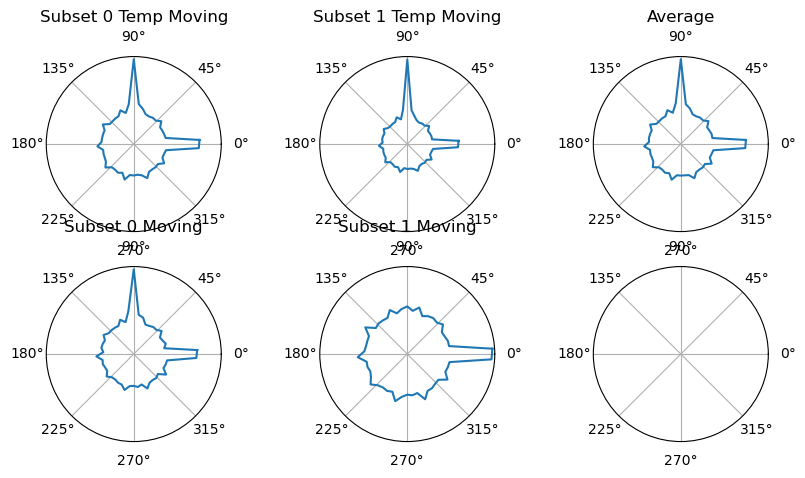

In [92]:

params = Params(
    N_TRIALS_PER_BATCH=20,
    N_BATCH=1,
    TEMPORAL_COHERENCES=[0.1, 0.9],
    SUBSET_FRACTIONS=[0.05, 0.05],
    SPATIAL_COHERENCES=[0.7, 0.7],
    DIFFUSION_SCALE=3,
    DIFFUSE_SUBSET=True,
    NAME='Gabriel',
    COMOD=False,
    N_ANGLES=2,
    COLOR_GROUPS=False,
    DENSITY=300 / np.pi / (150 ** 2),

)
angles = [0, 90]

rdk = RDK(None, params)
rdk.new_sample(angles)
angles = np.deg2rad(angles)

plot_rdk(rdk)
exp = Experiment(params=params, randomize=False)


In [93]:
exp.run()


In [82]:
max_mod_diff = lambda angle, chosen_angle :  np.minimum(
                    np.abs(angle - chosen_angle),
                    np.abs(angle - 360 - chosen_angle) % 180,
                )

In [94]:
[max_mod_diff(exp.results_pd['chosen_angles'], exp.results_pd[f'angles_{i}']).mean() for i in range(2)]

[38.247193319288144, 57.87802081114289]

## Comod Task

In [ ]:
from rdktools.rdk_stimuli import RDK


def plot_comod_rdk(n_angles):

    coherences = [1 / n_angles for _ in range(n_angles)]

    angles = np.linspace(0, 360, n_angles, endpoint=False)
    p_subset = [1 / n_angles for _ in range(n_angles)]
    params = Params(DOT_COHERENCE=coherences, N_DOTS=500)

    rdk = RDK(None, params, angles)

    plot_rdk(rdk, coherences[0])


controls = {"n_angles": widgets.IntSlider(4, min=2, max=20, step=1, style=style)}

interactive_plot = widgets.interactive(
    plot_comod_rdk, **controls, layout={"width": "5000px"}
)
display(interactive_plot)

interactive(children=(IntSlider(value=4, description='n_angles', max=20, min=2, style=SliderStyle(description_…

In [ ]:
spaced_out = np.linspace(0, 360, 4, endpoint=False)

In [ ]:
angles = np.random.randint(0, 360, 10)

In [ ]:
v_sum = np.vectorize(lambda d: spaced_out + d, signature="(n),(d)->(n, d)")
v_sum(angles)

ValueError: setting an array element with a sequence.

(10, 4)

In [ ]:
rdk.dots

<Group(500 sprites)>

In [ ]:
np.random.randint(0, 4)

1

In [ ]:
angles

array([  0.,  90., 180., 270.])